# Import Necessary libreries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
airlines_data=pd.read_excel("./Airlines+Data.xlsx")
airlines_data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# Data Understanding

In [3]:
airlines_data.shape

(96, 2)

In [4]:
airlines_data.isna().sum()

Month         0
Passengers    0
dtype: int64

In [5]:
airlines_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [6]:
airlines_data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


<AxesSubplot:>

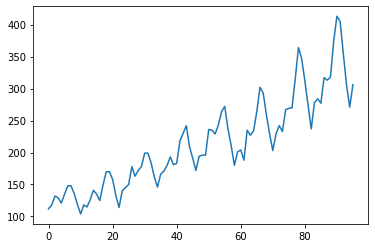

In [7]:
airlines_data.Passengers.plot()

# Data Preprocessing

In [8]:
airlines_data['Date']=pd.to_datetime(airlines_data['Month'],format="%b-%y")

In [9]:
airlines_data.head()

,Month,Passengers,Date
0,1995-01-01,112,1995-01-01
1,1995-02-01,118,1995-02-01
2,1995-03-01,132,1995-03-01
3,1995-04-01,129,1995-04-01
4,1995-05-01,121,1995-05-01


In [10]:
from datetime import datetime as dt

In [11]:
airlines_data["year"]=airlines_data["Date"].dt.strftime('%y')

In [12]:
airlines_data["month"]=airlines_data["Date"].dt.strftime('%b')

In [13]:
airlines_data.head()

,Month,Passengers,Date,year,month
0,1995-01-01,112,1995-01-01,95,Jan
1,1995-02-01,118,1995-02-01,95,Feb
2,1995-03-01,132,1995-03-01,95,Mar
3,1995-04-01,129,1995-04-01,95,Apr
4,1995-05-01,121,1995-05-01,95,May


In [14]:
dummy=(pd.get_dummies(data=airlines_data["month"]))
dummy

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,1,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,0,1
93,0,0,0,0,0,0,0,0,0,0,1,0
94,0,0,0,0,0,0,0,0,0,1,0,0


In [15]:
airlines_data=pd.concat([airlines_data,dummy],axis=1)
airlines_data

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,1995-01-01,95,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,1995-02-01,95,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,1995-03-01,95,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,1995-04-01,95,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,1995-05-01,95,May,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002-08-01,02,Aug,0,1,0,0,0,0,0,0,0,0,0,0
92,2002-09-01,355,2002-09-01,02,Sep,0,0,0,0,0,0,0,0,0,0,0,1
93,2002-10-01,306,2002-10-01,02,Oct,0,0,0,0,0,0,0,0,0,0,1,0
94,2002-11-01,271,2002-11-01,02,Nov,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
t=np.arange(1,(airlines_data.shape[0])+1,1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

In [17]:
t=pd.DataFrame(t)

In [18]:
t=t.rename({0:"t"},axis=1)
t

,t
0,1
1,2
2,3
3,4
4,5
...,...
91,92
92,93
93,94
94,95


In [19]:
airlines_data["t"]=t
airlines_data

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t
0,1995-01-01,112,1995-01-01,95,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1995-02-01,118,1995-02-01,95,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2
2,1995-03-01,132,1995-03-01,95,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3
3,1995-04-01,129,1995-04-01,95,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4
4,1995-05-01,121,1995-05-01,95,May,0,0,0,0,0,0,0,0,1,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002-08-01,02,Aug,0,1,0,0,0,0,0,0,0,0,0,0,92
92,2002-09-01,355,2002-09-01,02,Sep,0,0,0,0,0,0,0,0,0,0,0,1,93
93,2002-10-01,306,2002-10-01,02,Oct,0,0,0,0,0,0,0,0,0,0,1,0,94
94,2002-11-01,271,2002-11-01,02,Nov,0,0,0,0,0,0,0,0,0,1,0,0,95


In [20]:
airlines_data["log_passengers"]=np.log(airlines_data["Passengers"])
airlines_data["t_square"]=np.square(airlines_data["t"])

In [21]:
airlines_data

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square
0,1995-01-01,112,1995-01-01,95,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,4.718499,1
1,1995-02-01,118,1995-02-01,95,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4.770685,4
2,1995-03-01,132,1995-03-01,95,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,4.882802,9
3,1995-04-01,129,1995-04-01,95,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,4.859812,16
4,1995-05-01,121,1995-05-01,95,May,0,0,0,0,0,0,0,0,1,0,0,0,5,4.795791,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002-08-01,02,Aug,0,1,0,0,0,0,0,0,0,0,0,0,92,6.003887,8464
92,2002-09-01,355,2002-09-01,02,Sep,0,0,0,0,0,0,0,0,0,0,0,1,93,5.872118,8649
93,2002-10-01,306,2002-10-01,02,Oct,0,0,0,0,0,0,0,0,0,0,1,0,94,5.723585,8836
94,2002-11-01,271,2002-11-01,02,Nov,0,0,0,0,0,0,0,0,0,1,0,0,95,5.602119,9025


### Understanding the trend and seasonality of the time series

<AxesSubplot:>

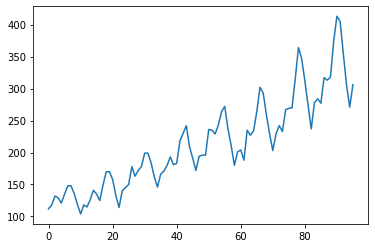

In [22]:
airlines_data.Passengers.plot()

### Distribution of Passengers

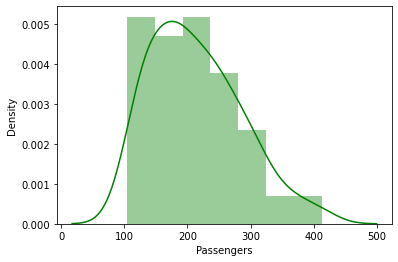

In [23]:
sns.distplot(airlines_data["Passengers"],color="g")
plt.show()

### Month wise and yearly Distribution of Passengers

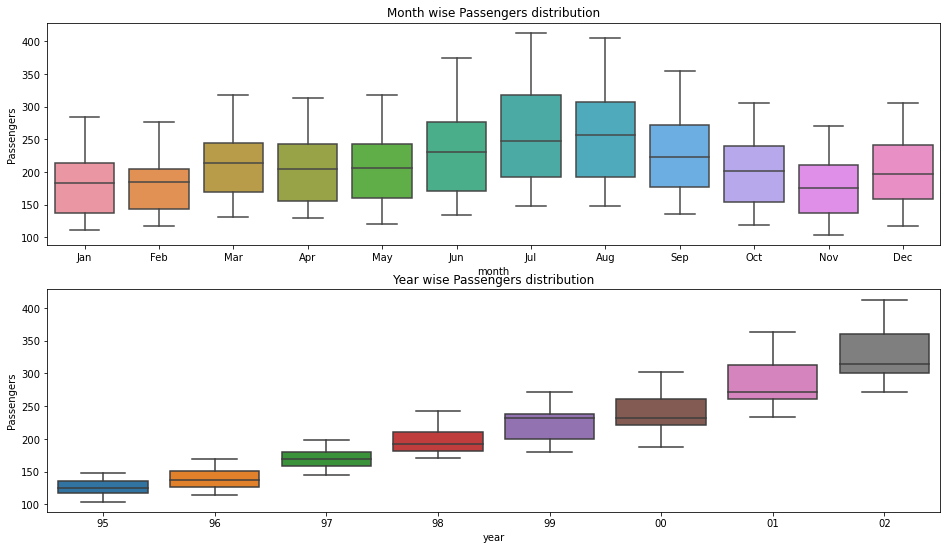

In [24]:
plt.figure(figsize=(16,9))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=airlines_data)
plt.title("Month wise Passengers distribution")
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=airlines_data)
plt.title("Year wise Passengers distribution")
plt.show()

### Understanding year wise Passengers distribution with Correlation matrix and Heatmap

In [73]:
pivot=pd.pivot_table(data=airlines_data,values='Passengers',index='month',columns='year')
pivot

year,00,01,02,95,96,97,98,99
month,,,,,,,,
Apr,227,269,313,129,135,163,181,235
Aug,293,347,405,148,170,199,242,272
Dec,229,278,306,118,140,166,194,201
Feb,188,233,277,118,126,150,180,196
Jan,204,242,284,112,115,145,171,196
Jul,302,364,413,148,170,199,230,264
Jun,264,315,374,135,149,178,218,243
Mar,235,267,317,132,141,178,193,236
May,234,270,318,121,125,172,183,229


In [74]:
pivot.corr()

year,00,01,02,95,96,97,98,99
year,,,,,,,,
00,1.000000,0.989433,0.984947,0.911553,0.930967,0.959165,0.942879,0.913945
01,0.989433,1.000000,0.985527,0.908190,0.949866,0.939515,0.956044,0.884986
02,0.984947,0.985527,1.000000,0.940419,0.938707,0.946961,0.960854,0.929524
95,0.911553,0.908190,0.940419,1.000000,0.949435,0.944994,0.905623,0.970144
96,0.930967,0.949866,0.938707,0.949435,1.000000,0.946923,0.957062,0.880477
97,0.959165,0.939515,0.946961,0.944994,0.946923,1.000000,0.923131,0.939609
98,0.942879,0.956044,0.960854,0.905623,0.957062,0.923131,1.000000,0.861005
99,0.913945,0.884986,0.929524,0.970144,0.880477,0.939609,0.861005,1.000000


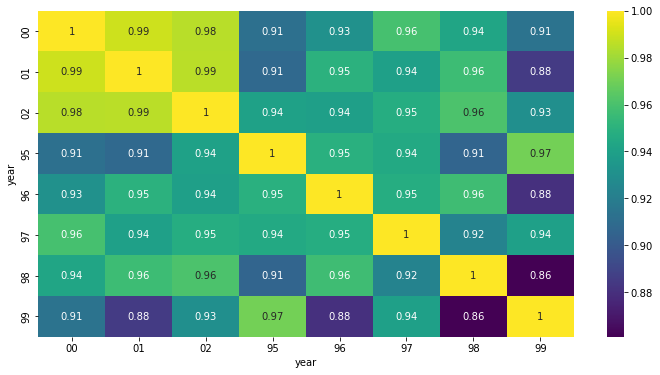

In [80]:
plt.figure(figsize=(12,6))
sns.heatmap(data=pivot.corr(),annot=True,cmap='viridis')
plt.show()

## Line plot

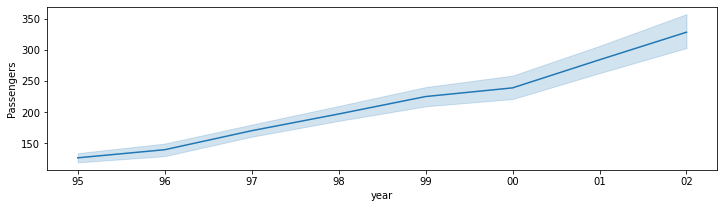

In [25]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=airlines_data)
plt.show()

## Lag plot

In [26]:
from pandas.plotting import lag_plot

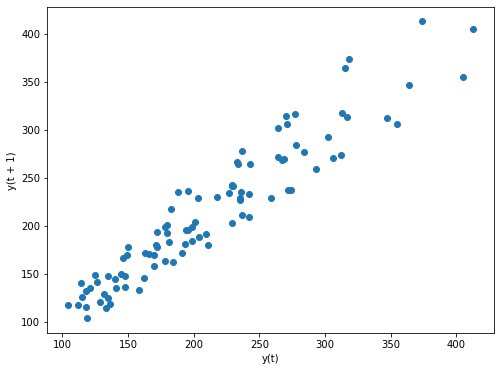

In [27]:
plt.figure(figsize=(8,6))
lag_plot(airlines_data['Passengers'])
plt.show()

###   From the plot we can see that the Models can be  built

## ACF and PACF plots

### ACF - plot between lags and values of correlation

### PACF - partial auto-correlation function, plot between lags and residuals 

### (Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals)

In [28]:
import statsmodels.graphics.tsaplots as tsa_plots

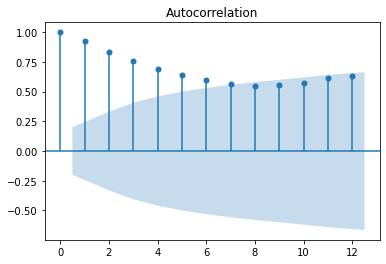

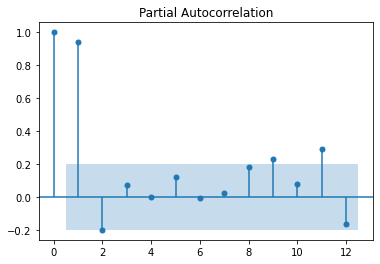

In [29]:
tsa_plots.plot_acf(airlines_data.Passengers,lags=12)
tsa_plots.plot_pacf(airlines_data.Passengers,lags=12)
plt.show()

### Time series decomposition plot

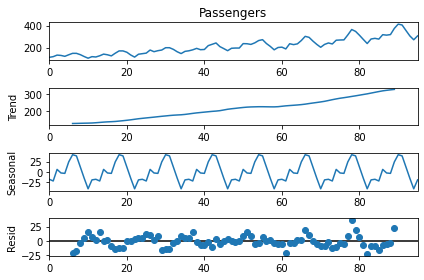

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(airlines_data['Passengers'],period=12)
decompose_ts_add.plot()
plt.show()

## Data Splitting

In [31]:
airlines_data

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square
0,1995-01-01,112,1995-01-01,95,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,4.718499,1
1,1995-02-01,118,1995-02-01,95,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4.770685,4
2,1995-03-01,132,1995-03-01,95,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,4.882802,9
3,1995-04-01,129,1995-04-01,95,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,4.859812,16
4,1995-05-01,121,1995-05-01,95,May,0,0,0,0,0,0,0,0,1,0,0,0,5,4.795791,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002-08-01,02,Aug,0,1,0,0,0,0,0,0,0,0,0,0,92,6.003887,8464
92,2002-09-01,355,2002-09-01,02,Sep,0,0,0,0,0,0,0,0,0,0,0,1,93,5.872118,8649
93,2002-10-01,306,2002-10-01,02,Oct,0,0,0,0,0,0,0,0,0,0,1,0,94,5.723585,8836
94,2002-11-01,271,2002-11-01,02,Nov,0,0,0,0,0,0,0,0,0,1,0,0,95,5.602119,9025


In [32]:
train=airlines_data.head(84)
test=airlines_data.tail(12)

In [33]:
train

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square
0,1995-01-01,112,1995-01-01,95,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,4.718499,1
1,1995-02-01,118,1995-02-01,95,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4.770685,4
2,1995-03-01,132,1995-03-01,95,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,4.882802,9
3,1995-04-01,129,1995-04-01,95,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,4.859812,16
4,1995-05-01,121,1995-05-01,95,May,0,0,0,0,0,0,0,0,1,0,0,0,5,4.795791,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2001-08-01,347,2001-08-01,01,Aug,0,1,0,0,0,0,0,0,0,0,0,0,80,5.849325,6400
80,2001-09-01,312,2001-09-01,01,Sep,0,0,0,0,0,0,0,0,0,0,0,1,81,5.743003,6561
81,2001-10-01,274,2001-10-01,01,Oct,0,0,0,0,0,0,0,0,0,0,1,0,82,5.613128,6724
82,2001-11-01,237,2001-11-01,01,Nov,0,0,0,0,0,0,0,0,0,1,0,0,83,5.468060,6889


In [34]:
test

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square
84,2002-01-01,284,2002-01-01,02,Jan,0,0,0,0,1,0,0,0,0,0,0,0,85,5.648974,7225
85,2002-02-01,277,2002-02-01,02,Feb,0,0,0,1,0,0,0,0,0,0,0,0,86,5.624018,7396
86,2002-03-01,317,2002-03-01,02,Mar,0,0,0,0,0,0,0,1,0,0,0,0,87,5.758902,7569
87,2002-04-01,313,2002-04-01,02,Apr,1,0,0,0,0,0,0,0,0,0,0,0,88,5.746203,7744
88,2002-05-01,318,2002-05-01,02,May,0,0,0,0,0,0,0,0,1,0,0,0,89,5.762051,7921
89,2002-06-01,374,2002-06-01,02,Jun,0,0,0,0,0,0,1,0,0,0,0,0,90,5.924256,8100
90,2002-07-01,413,2002-07-01,02,Jul,0,0,0,0,0,1,0,0,0,0,0,0,91,6.023448,8281
91,2002-08-01,405,2002-08-01,02,Aug,0,1,0,0,0,0,0,0,0,0,0,0,92,6.003887,8464
92,2002-09-01,355,2002-09-01,02,Sep,0,0,0,0,0,0,0,0,0,0,0,1,93,5.872118,8649
93,2002-10-01,306,2002-10-01,02,Oct,0,0,0,0,0,0,0,0,0,0,1,0,94,5.723585,8836


# Model Building

## Model based Forcasting Techniques

### Linear model

In [35]:
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error

In [36]:
linear_model = smf.ols('Passengers~t',data=train).fit()
linear_pred=linear_model.predict(test['t'])

linear_rms=mean_absolute_percentage_error(test['Passengers'],linear_pred)*100
linear_rms

10.78745878026367

####  Brief of the model

1.dependent variable= Passengers
2.independent variable= t
3.RMSE matric =  10.78

###  Exponential model

In [37]:
Exp = smf.ols('log_passengers~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = mean_absolute_percentage_error(test['log_passengers'],pred_Exp)*100
rmse_Exp

1.8592213245555795

####  Brief of the model
1.dependent variable= log_Passengers
2.independent variable= t
3.RMSE matric =  1.85

### Quadratic Model

In [38]:
Quad = smf.ols('Passengers~t+t_square',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_square"]]))
rmse_Quad = mean_absolute_percentage_error(test['Passengers'],pred_Quad)*100
rmse_Quad

10.685102719319657

####  Brief of the model
1.dependent variable= Passengers
2.independent variable= t,t_square
3.RMSE matric =  10.68

### Additive seasonality 

In [39]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = mean_absolute_percentage_error(test['Passengers'],pred_add_sea)*100
rmse_add_sea
rmse_add_sea

39.728616686874396

####  Brief of the model
1.dependent variable= Passengers

2.independent variable= Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov

3.RMSE matric =  39.72

### Additive Seasonality Quadratic 

In [40]:
add_sea_Quad = smf.ols('Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_add_sea_quad = mean_absolute_percentage_error(test['Passengers'],pred_add_sea_quad)*100
rmse_add_sea_quad

5.1076452779209776

####  Brief of the model
1.dependent variable= Passengers

2.independent variable= t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov

3.RMSE matric =  5.10

### Multiplicative Seasonality

In [41]:
Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = mean_absolute_percentage_error(test['log_passengers'],pred_Mult_sea)*100
rmse_Mult_sea

9.383858630779724

####  Brief of the model
1.dependent variable= log_Passengers

2.independent variable= Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov

3.RMSE matric =  9.38

### Additive Seasonality With Linear Trend

In [42]:
Lin_Add_sea = smf.ols('Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Lin_add_sea = pd.Series(Lin_Add_sea.predict(test))
rmse_Lin_add_sea = mean_absolute_percentage_error(test['Passengers'],pred_Lin_add_sea)*100
rmse_Lin_add_sea

7.578667788535874

####  Brief of the model
1.dependent variable= Passengers

2.independent variable= t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov

3.RMSE matric =  7.57

### Multiplicative Additive Seasonality 

In [43]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = mean_absolute_percentage_error(test['log_passengers'],pred_Mult_add_sea)*100
rmse_Mult_add_sea 

0.4102473253217985

####  Brief of the model
1.dependent variable= log_Passengers

2.independent variable= t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov

3.RMSE matric =  0.41

In [44]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     244.0
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           1.21e-52
Time:                        17:34:53   Log-Likelihood:                 140.25
No. Observations:                  84   AIC:                            -254.5
Df Residuals:                      71   BIC:                            -222.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6713      0.022    215.952      0.000       4.628       4.714
t              0.0112      0.000     49.637      0.000       0.011       0.012
Jan            0.0102      0.027      0.383      0.703      -0.043       0.063
Feb            0.0146      0.027      0.549      0.584      -0.038       0.068
Mar            0.1478      0.027      5.562      0.000       0.095       0.201
Apr            0.1009      0.027      3.799      0.000       0.048       0.154
May            0.0800      0.027      3.013      0.004       0.027       0.133
Jun            0.1871      0.027      7.055      0.000       0.134       0.240
Jul            0.2832      0.027     10.681      0.000       0.230       0.336
Aug            0.2724      0.027     10.277      0.000       0.220       0.325
Sep            0.1541      0.027      5.814      0.000       0.101       0.207
Oct            0.0154      0.026      0.581      0.563      -0.037       0.068
Nov           -0.1275      0.026     -4.813      0.000      -0.180      -0.075
==============================================================================
Omnibus:                        1.428   Durbin-Watson:                   0.642
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                0.867
Skew:                          -0.198   Prob(JB):                        0.648
Kurtosis:                       3.302   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observation:

### In the Model Based Techniques Multiplicative  Additive Seasonality model is best performing

## Data Driven Forcasting

###  Moving average

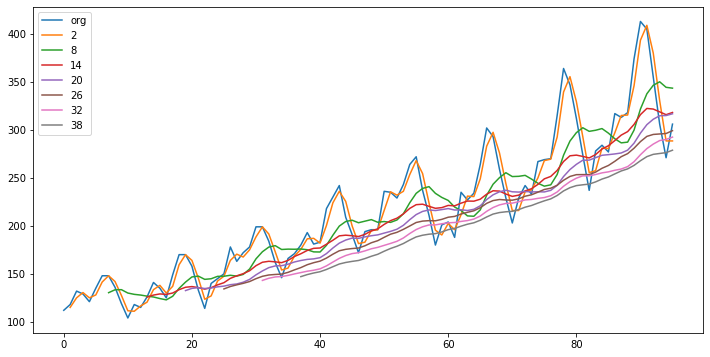

In [45]:
plt.figure(figsize=(12,6))
airlines_data['Passengers'].plot(label="org")
for i in range(2,43,6):
    airlines_data['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

### Obs : Moving avg model not performed well

### Simple Exponential Smoothing model

In [46]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [47]:
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])

ses_rms=mean_absolute_percentage_error(pred_ses,test['Passengers'])*100 
ses_rms

17.236298389625826

#### Brief of the model
RMSE_metric=17.23

### Holt's  Trend model

In [48]:
# forcast - based on current time, trend
from statsmodels.tsa.holtwinters import Holt

hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2) # two levels of smoothening
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
hw_rms=mean_absolute_percentage_error(pred_hw,test['Passengers'])*100 
hw_rms

33.788331370467375

#### Brief of the model
RMSE_metric=33.78

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [49]:
# forcast - based on current time, trend, seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # three levels of smoothening

hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])

hw_ma_rms=mean_absolute_percentage_error(pred_hwe_mul_add,test['Passengers'])*100 
hw_ma_rms

2.9417209206745984

#### Brief of the model
RMSE_metric= 2.94

### Holts winter exponential smoothing with additive seasonality and multiplicative trend

In [50]:
# forcast - based on current time, trend, seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # three levels of smoothening

hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="mul",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])

hw_ma_rms=mean_absolute_percentage_error(pred_hwe_mul_add,test['Passengers'])*100 
hw_ma_rms

2.098345014608848

#### Brief of the model
RMSE_metric= 2.09

### Holts winter exponential smoothing with additive seasonality and additive trend

In [51]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])

hw_aa_rms=mean_absolute_percentage_error(pred_hwe_add_add,test['Passengers'])*100 
hw_aa_rms

6.101139971892924

#### Brief of the model
RMSE_metric=6.10

### Observation:

### In the Data Driven Forecasting model ->  Holts winter exponential smoothing with additive seasonality and multiplicative trend  model is best performing 

### ARMA Model (Auto regression and Moving Average)

In [52]:
from statsmodels.tsa.arima_model import ARMA

In [53]:
ARMAmodel = ARMA(endog=train['Passengers'],order=(2, 0)) #model with AR=1 and MA=0
ARMAmodel_fit = ARMAmodel.fit()

ARMA_pred = ARMAmodel_fit.predict(start = test.index[0],end = test.index[-1])
ARMA_pred

arma_rms=mean_absolute_percentage_error(ARMA_pred,test['Passengers'])*100 
arma_rms

32.12826934716185

#### Brief of the model
RMSE_metric=32.12

### ARIMA (Autoregressive Integrated Moving Average)

### -> It's only Applicable for Stationary Data 

###  Understanding the rolling pattern

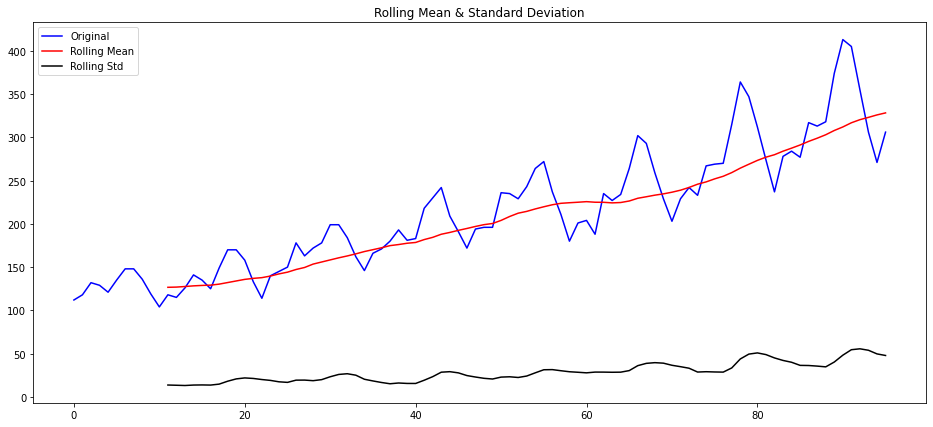

In [54]:
rolLmean = airlines_data['Passengers'].rolling(12).mean() # 12 entries
rolLstd = airlines_data['Passengers'].rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(airlines_data['Passengers'], color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### obs:  Data is not stationary

### Transformation

### To transform to stationary from non-stationary

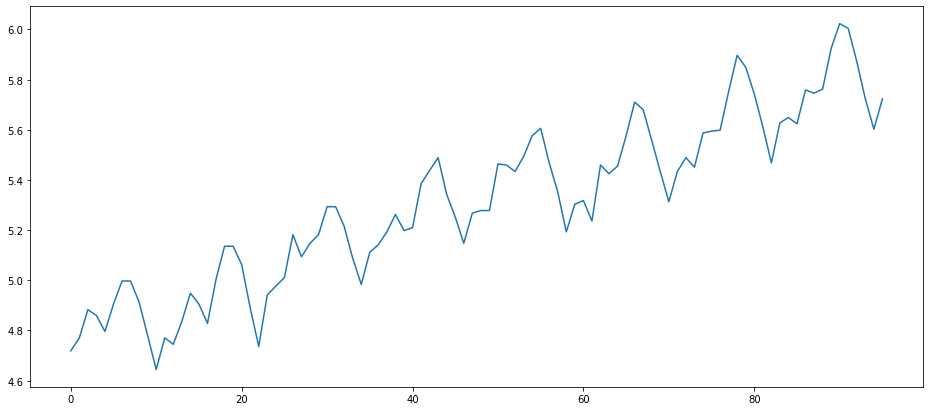

In [55]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(airlines_data['Passengers'])#to transform to stationary from non-stationary
plt.plot(ts_log)

### Obs : Data is not stationary

### Differencing Method (To achieve Stationary data)

### Differencing  Method

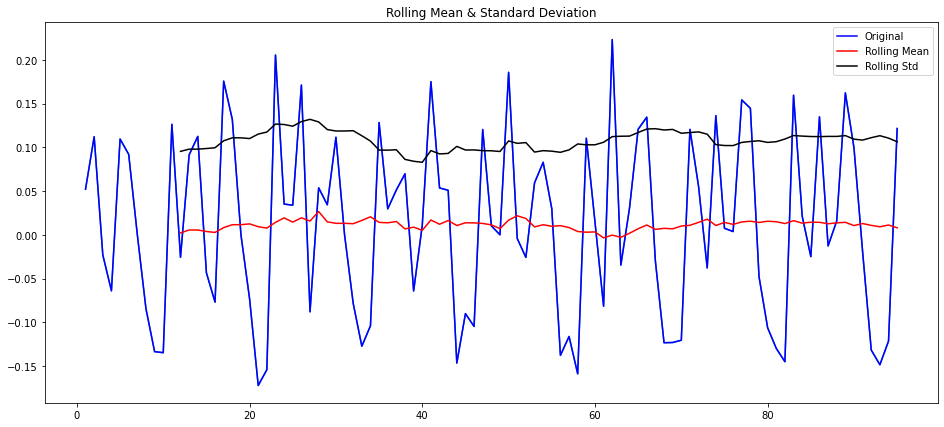

In [56]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift(periods=1) # I will shift the time series by 1 and subtract from the original TS.
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [57]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12)

### ACF And PACF Plot

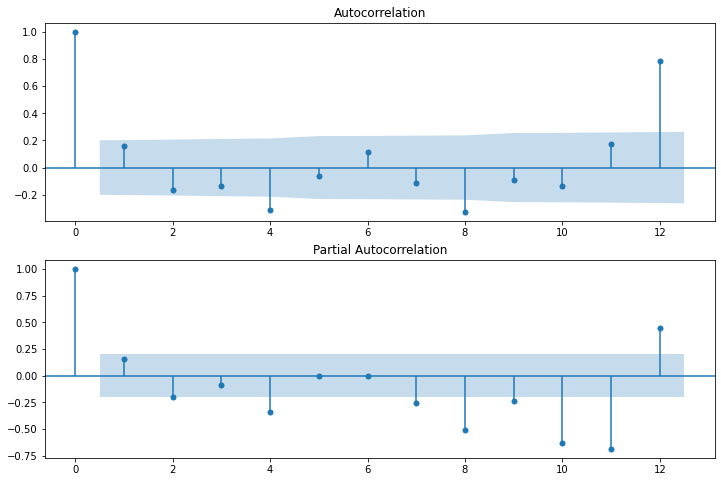

In [58]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=12,ax=ax2)

### ACF - plot between lags and values of correlation

### PACF - partial auto-correlation function, plot between lags and residuals 

### (Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals)

### Lets Tweak the variables for the Arima Model

In [59]:
import itertools
p = range(0,5) #AR order
d = range(0,5) #Shift
q = range(0,5) #MA order
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [60]:
from statsmodels.tsa.arima_model import ARIMA
for param in pdq:
    try:
        model_arima = ARIMA(train['Passengers'],order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 925.6168071633045
(0, 0, 1) 836.8163599503866
(0, 0, 2) 797.7448102710107
(0, 0, 3) 769.027062300019
(0, 0, 4) 770.0039476223571
(0, 1, 0) 747.1473889498182
(0, 1, 1) 743.8152956902227
(0, 1, 2) 735.5269358594556
(0, 1, 3) 730.7331331368179
(0, 1, 4) 724.4344326520627
(0, 2, 0) 775.5632133945176
(0, 2, 1) 745.6048212112098
(0, 2, 2) 741.7925600773063
(0, 2, 3) 741.0973869079363
(0, 2, 4) 732.6850426882938
(1, 0, 0) 758.9393761041717
(1, 0, 1) 754.0226919192378
(1, 0, 2) 754.794792163354
(1, 0, 3) 832.6581024766235
(1, 1, 0) 745.6461131853492
(1, 1, 1) 742.6453919831263
(1, 1, 2) 728.0416618631339
(1, 1, 3) 729.8707992613384
(1, 1, 4) 726.2116435940618
(1, 2, 0) 772.5348834448741
(1, 2, 1) 743.6720395603747
(1, 2, 2) 740.9275496941235
(1, 2, 3) 742.147051552186
(1, 2, 4) 743.6122214821388
(2, 0, 0) 755.8486368613912
(2, 0, 1) 753.9577649887002
(2, 1, 0) 743.3072974472858
(2, 1, 1) 724.7862372480594
(2, 1, 2) 721.8868799357886
(2, 1, 3) 742.995354996117
(2, 2, 0) 767.1226854137

### Observation
###  i take the values of   p,d and q  for which  aic is minimum

In [61]:
ARIMAmodel = ARIMA(train['Passengers'], order=(4, 1, 4)) #notice p,d and q value here
ARIMA_model_fit = ARIMAmodel.fit()

ARIMA_pred = ARIMA_model_fit.predict(start = test.index[0],end = test.index[-1],typ='levels')

arima_rms=mean_absolute_percentage_error(ARIMA_pred,test['Passengers'])*100
arima_rms

11.926677851456633

#### Brief of the model
RMSE_metric=11.92

#### Forecasting with ARIMA model ->  For next 12 months

In [88]:
pd.DataFrame(ARIMA_model_fit.forecast(12)[0])

,0
0,265.585893
1,244.259641
2,243.477307
3,270.724331
4,309.664415
5,339.060606
6,349.265009
7,343.657128
8,330.002289
9,313.279128


## From the above Analysis   -->  Multiplicative  Additive Seasonality model is best performing

## Final model

### Training with complete data

In [62]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = airlines_data).fit()

In [63]:
airlines_data.tail(3)

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square
93,2002-10-01,306,2002-10-01,02,Oct,0,0,0,0,0,0,0,0,0,0,1,0,94,5.723585,8836
94,2002-11-01,271,2002-11-01,02,Nov,0,0,0,0,0,0,0,0,0,1,0,0,95,5.602119,9025
95,2002-12-01,306,2002-12-01,02,Dec,0,0,1,0,0,0,0,0,0,0,0,0,96,5.723585,9216


### Unknown data to be forecasted

In [64]:
forecast_data=pd.read_excel("./airlines_forcast.xlsx")
forecast_data

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square
0,2003-01-01,NaN,NaN,2003,Jan,0,0,0,0,1,0,0,0,0,0,0,0,97,NaN,9409
1,2003-02-01,NaN,NaN,2003,Feb,0,0,0,1,0,0,0,0,0,0,0,0,98,NaN,9604
2,2003-03-01,NaN,NaN,2003,Mar,0,0,0,0,0,0,0,1,0,0,0,0,99,NaN,9801
3,2003-04-01,NaN,NaN,2003,Apr,1,0,0,0,0,0,0,0,0,0,0,0,100,NaN,10000
4,2003-05-01,NaN,NaN,2003,May,0,0,0,0,0,0,0,0,1,0,0,0,101,NaN,10201
5,2003-06-01,NaN,NaN,2003,Jun,0,0,0,0,0,0,1,0,0,0,0,0,102,NaN,10404
6,2003-07-01,NaN,NaN,2003,Jul,0,0,0,0,0,1,0,0,0,0,0,0,103,NaN,10609
7,2003-08-01,NaN,NaN,2003,Aug,0,1,0,0,0,0,0,0,0,0,0,0,104,NaN,10816
8,2003-09-01,NaN,NaN,2003,Sep,0,0,0,0,0,0,0,0,0,0,0,1,105,NaN,11025


### Forecasting Prediction

In [65]:
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(forecast_data))

In [66]:
pred_Mult_add_sea 

0    5.770755
1    5.781280
2    5.924459
3    5.891606
4    5.885083
5    6.008926
6    6.115180
7    6.113063
8    6.002824
dtype: float64

In [67]:
forecast_data["forecasted_Passengers"]=pred_Mult_add_sea

In [68]:
forecast_data

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,...,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square,forecasted_Passengers
0,2003-01-01,NaN,NaN,2003,Jan,0,0,0,0,1,...,0,0,0,0,0,0,97,NaN,9409,5.770755
1,2003-02-01,NaN,NaN,2003,Feb,0,0,0,1,0,...,0,0,0,0,0,0,98,NaN,9604,5.781280
2,2003-03-01,NaN,NaN,2003,Mar,0,0,0,0,0,...,0,1,0,0,0,0,99,NaN,9801,5.924459
3,2003-04-01,NaN,NaN,2003,Apr,1,0,0,0,0,...,0,0,0,0,0,0,100,NaN,10000,5.891606
4,2003-05-01,NaN,NaN,2003,May,0,0,0,0,0,...,0,0,1,0,0,0,101,NaN,10201,5.885083
5,2003-06-01,NaN,NaN,2003,Jun,0,0,0,0,0,...,1,0,0,0,0,0,102,NaN,10404,6.008926
6,2003-07-01,NaN,NaN,2003,Jul,0,0,0,0,0,...,0,0,0,0,0,0,103,NaN,10609,6.115180
7,2003-08-01,NaN,NaN,2003,Aug,0,1,0,0,0,...,0,0,0,0,0,0,104,NaN,10816,6.113063
8,2003-09-01,NaN,NaN,2003,Sep,0,0,0,0,0,...,0,0,0,0,0,1,105,NaN,11025,6.002824


In [69]:
airlines_data_2=airlines_data.copy()

In [70]:
complete_data=pd.concat([airlines_data_2,forecast_data])

In [71]:
complete_data

,Month,Passengers,Date,year,month,Apr,Aug,Dec,Feb,Jan,...,Jun,Mar,May,Nov,Oct,Sep,t,log_passengers,t_square,forecasted_Passengers
0,1995-01-01,112.0,1995-01-01,95,Jan,0,0,0,0,1,...,0,0,0,0,0,0,1,4.718499,1,NaN
1,1995-02-01,118.0,1995-02-01,95,Feb,0,0,0,1,0,...,0,0,0,0,0,0,2,4.770685,4,NaN
2,1995-03-01,132.0,1995-03-01,95,Mar,0,0,0,0,0,...,0,1,0,0,0,0,3,4.882802,9,NaN
3,1995-04-01,129.0,1995-04-01,95,Apr,1,0,0,0,0,...,0,0,0,0,0,0,4,4.859812,16,NaN
4,1995-05-01,121.0,1995-05-01,95,May,0,0,0,0,0,...,0,0,1,0,0,0,5,4.795791,25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2003-05-01,NaN,NaT,2003,May,0,0,0,0,0,...,0,0,1,0,0,0,101,NaN,10201,5.885083
5,2003-06-01,NaN,NaT,2003,Jun,0,0,0,0,0,...,1,0,0,0,0,0,102,NaN,10404,6.008926
6,2003-07-01,NaN,NaT,2003,Jul,0,0,0,0,0,...,0,0,0,0,0,0,103,NaN,10609,6.115180
7,2003-08-01,NaN,NaT,2003,Aug,0,1,0,0,0,...,0,0,0,0,0,0,104,NaN,10816,6.113063


## Forecasting Plot
###    (Plot of Passengers  and Forcasted Passengers)

<AxesSubplot:>

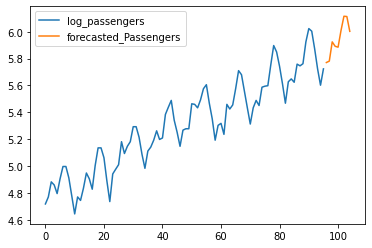

In [72]:
complete_data[["log_passengers","forecasted_Passengers"]].reset_index(drop=True).plot()